In [ ]:
import os
import shutil

# Define the source and destination directories
source_dir = '/mnt/data/SAVE_LOCAL'
destination_dir = '/content'

# Create a list to store the results
copy_results = []

# Check if the source directory exists
if not os.path.exists(source_dir):
    # If the source directory doesn't exist, create an empty one to mimic the structure
    os.makedirs(source_dir)

# Copy all the files from the source directory to the destination
for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)
    if os.path.isfile(file_path):
        shutil.copy(file_path, destination_dir)
        copy_results.append(f"Copied {filename} to {destination_dir}")

# If no files were found, add a message
if not copy_results:
    copy_results.append("No files found in SAVE_LOCAL to copy.")

copy_results

['No files found in SAVE_LOCAL to copy.']

In [56]:
!pip -q install datasets transformers regex SentencePiece transformers[torch] torch pandas


In [57]:
import os
import re
from datasets import load_dataset
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, Trainer, TrainingArguments


In [58]:
# Define model name and load tokenizer and model
dataset_name = "pubmed"
model_name = f"google/pegasus-{dataset_name}"
formatted_model_name = model_name.replace("/", "_")
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)


(…)ubmed/resolve/main/tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

(…)pegasus-pubmed/resolve/main/spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

(…)med/resolve/main/special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

(…)/pegasus-pubmed/resolve/main/config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-pubmed and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(…)bmed/resolve/main/generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [59]:
# Directory paths
raw_data_dir = f"./{dataset_name}_raw_data_{formatted_model_name}"
tokenized_data_dir = f"./{dataset_name}_tokenized_{formatted_model_name}"
finetuned_model_dir = f"./finetuned_{dataset_name}_{formatted_model_name}"


# Create directories if they don't exist
os.makedirs(raw_data_dir, exist_ok=True)
os.makedirs(tokenized_data_dir, exist_ok=True)
os.makedirs(finetuned_model_dir, exist_ok=True)

In [60]:
dataset = load_dataset("scientific_papers", dataset_name)
train_dataset = dataset["train"].select(range(1000))
validation_dataset = dataset["validation"].select(range(100))
test_dataset = dataset["test"].select(range(100))

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/119924 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6633 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6658 [00:00<?, ? examples/s]

In [61]:
# Save raw datasets
train_dataset.save_to_disk(f"{raw_data_dir}/train")
validation_dataset.save_to_disk(f"{raw_data_dir}/validation")
test_dataset.save_to_disk(f"{raw_data_dir}/test")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

In [63]:
 # Load the raw datasets
train_dataset = load_from_disk(f"{raw_data_dir}/train")
validation_dataset = load_from_disk(f"{raw_data_dir}/validation")
test_dataset = load_from_disk(f"{raw_data_dir}/test")

In [64]:
  import torch
  torch.cuda.set_device(0)
  model.to('cuda')

PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(1024, 1024)
      (layers): ModuleList(
        (0-15): 16 x PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_no

In [65]:
def preprocess_function(examples):
    clean_abstracts = [re.sub(r'(@xCite)|(@xMath)|(\$.*?\$)', '', abstract) for abstract in examples['abstract']]
    clean_articles = [re.sub(r'(@xCite)|(@xMath)|(\$.*?\$)', '', article) for article in examples['article']]
    return {'article': clean_articles, 'abstract': clean_abstracts}


In [66]:
def tokenize_function(examples):
    # Tokenize the articles
    model_inputs = tokenizer(examples["article"], max_length=1024, truncation=True, padding="max_length")

    # Tokenize the abstracts as labels
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["abstract"], max_length=128, truncation=True, padding="max_length")

    # The Pegasus tokenizer automatically sets padding tokens to -100 which is ignored in loss computation
    model_inputs["labels"] = [label if label != tokenizer.pad_token_id else -100 for label in labels["input_ids"]]
    return model_inputs

In [67]:
# Apply preprocessing and tokenization
train_dataset = train_dataset.map(preprocess_function, batched=True)
validation_dataset = validation_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_validation = validation_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [68]:

tokenized_train.save_to_disk(f"{tokenized_data_dir}/train")
tokenized_validation.save_to_disk(f"{tokenized_data_dir}/validation")
tokenized_test.save_to_disk(f"{tokenized_data_dir}/test")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

In [70]:
# Load the tokenized datasets
tokenized_train = load_from_disk(f"{tokenized_data_dir}/train")
tokenized_validation = load_from_disk(f"{tokenized_data_dir}/validation")
tokenized_test = load_from_disk(f"{tokenized_data_dir}/test")

In [74]:
training_args = TrainingArguments(
    output_dir=f"./{dataset_name}_{model_name}training_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=3,
)

In [75]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer
)

In [76]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,2.340968
2,1.650300,2.317228
3,1.650300,2.308554
4,1.470200,2.308148
5,1.470200,2.306352


TrainOutput(global_step=1250, training_loss=1.53563056640625, metrics={'train_runtime': 867.6148, 'train_samples_per_second': 5.763, 'train_steps_per_second': 1.441, 'total_flos': 1.444732207104e+16, 'train_loss': 1.53563056640625, 'epoch': 5.0})

In [77]:
# Save the fine-tuned model
model.save_pretrained(finetuned_model_dir)
tokenizer.save_pretrained(finetuned_model_dir)

('./finetuned_pubmed_google_pegasus-pubmed/tokenizer_config.json',
 './finetuned_pubmed_google_pegasus-pubmed/special_tokens_map.json',
 './finetuned_pubmed_google_pegasus-pubmed/spiece.model',
 './finetuned_pubmed_google_pegasus-pubmed/added_tokens.json')

### **BREAK**

In [79]:
# Load the fine-tuned model and tokenizer
dataset_name = "pubmed"
model_name = f"google/pegasus-{dataset_name}"
finetuned_model_dir = f"./finetuned_{dataset_name}_{model_name.replace('/', '_')}"

model = PegasusForConditionalGeneration.from_pretrained(finetuned_model_dir)
tokenizer = PegasusTokenizer.from_pretrained(finetuned_model_dir)

In [80]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

def postprocess_summary(summary):
    redundant_phrases = ["In this paper,", "In this work"]
    for phrase in redundant_phrases:
        summary = summary.replace(phrase, "")
    return summary.strip()

def summarize_segment(segment, model, tokenizer, max_length=1024, min_length=64):
    tokens = tokenizer(segment, truncation=True, padding="longest", return_tensors="pt")
    summary_ids = model.generate(tokens["input_ids"], num_beams=4, max_length=max_length, min_length=min_length, length_penalty=2.0, no_repeat_ngram_size=3, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return postprocess_summary(summary)

def count_words(text):
    return len(text.split())

def sliding_window_summarization(document_text, summary_length=256, window_size=600, step_size=300, model_name="google/pegasus-xsum"):
    tokenizer = PegasusTokenizer.from_pretrained(model_name)
    model = PegasusForConditionalGeneration.from_pretrained(model_name)

    tokens = tokenizer(document_text, return_tensors="pt", truncation=False)["input_ids"][0]

    summarized_text = ""
    words_count = 0
    for i in range(0, len(tokens), step_size):
        if words_count >= summary_length:
            break
        window_end = min(i + window_size, len(tokens))
        window = tokens[i:window_end]
        segment_text = tokenizer.decode(window, skip_special_tokens=True)
        segment_summary = summarize_segment(segment_text, model, tokenizer)
        segment_word_count = count_words(segment_summary)
        if words_count + segment_word_count > summary_length:
            break
        summarized_text += segment_summary + " "
        words_count += segment_word_count

    return summarized_text.strip()

In [82]:
# Example usage
document_text = open('sample.txt', 'r').read()
summary = sliding_window_summarization(document_text, summary_length=512)  # You can change summary_length as needed
print("Summary:")
print(summary)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (4933 > 512). Running this sequence through the model will result in indexing errors


Summary:
The importance of publishing papers in English is based upon several factors: 1) English remains the most commonly used language for medical publications (both online and the traditional paper format); 2) Most of the higher impact factor journals are published in English; 3) Publications in English improve visibility of the author and institution and can be vital to one’s academic promotion (1) since there are no specific rules about how to publish in English. How to write a paper in English and how to increase the chances that your manuscript will be published Here are some tips for writing a manuscript in English that will help you make a good first impression and increase the likelihood that your paper will be accepted for publication in a medical journal., 2012; 13(S1):S1-S11. In our series of letters from authors, surgeon and other health care professionals look at the importance of the “presentation” of a manuscript to the journal that will accept it for publication (see

### EVAL

In [ ]:
def sliding_window_summarization_evaluation(document_text, summary_length=256, window_size=600, step_size=300, model=None, tokenizer=None):
    tokens = tokenizer(document_text, return_tensors="pt", truncation=False)["input_ids"][0]

    summarized_text = ""
    words_count = 0
    for i in range(0, len(tokens), step_size):
        if words_count >= summary_length:
            break
        window_end = min(i + window_size, len(tokens))
        window = tokens[i:window_end]
        segment_text = tokenizer.decode(window, skip_special_tokens=True)
        segment_summary = summarize_segment(segment_text, model, tokenizer)
        segment_word_count = count_words(segment_summary)
        if words_count + segment_word_count > summary_length:
            break
        summarized_text += segment_summary + " "
        words_count += segment_word_count

    return summarized_text.strip()

In [ ]:
!pip install -q datasets transformers sentencepiece transformers[torch] torch pandas matplotlib seaborn nltk rouge sacrebleu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import pandas as pd
from datasets import load_dataset, load_from_disk
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu

# Define model and dataset information
dataset_name = "arxiv"
model_name = f"google/pegasus-{dataset_name}"
formatted_model_name = model_name.replace("/", "_")
eval_type = "rouge"  

In [ ]:
# Load test dataset
tokenized_data_dir = f"./{dataset_name}_tokenized_{formatted_model_name}/test"
test_dataset = load_from_disk(tokenized_data_dir)

In [ ]:
# Load the fine-tuned model and tokenizer
finetuned_model_dir = f"./finetuned_{dataset_name}_{formatted_model_name}"
model = PegasusForConditionalGeneration.from_pretrained(finetuned_model_dir)
tokenizer = PegasusTokenizer.from_pretrained(finetuned_model_dir)

In [ ]:
# Initialize Rouge
rouge = Rouge()

# Initialize lists to store Rouge scores
rouge_scores = []


In [83]:
# Define the number of examples to evaluate 
num_examples_to_evaluate = 30

# Initialize a variable to accumulate Rouge scores
total_rouge_scores = {"rouge-1": {"f": 0.0, "p": 0.0, "r": 0.0}, "rouge-2": {"f": 0.0, "p": 0.0, "r": 0.0}, "rouge-l": {"f": 0.0, "p": 0.0, "r": 0.0}}

# Evaluate Rouge for each example in the test dataset 
for i, example in enumerate(test_dataset):
    if i >= num_examples_to_evaluate:
        break

    article = example["article"]
    abstract = example["abstract"]

    # Generate a summary using the fine-tuned model
    summary = sliding_window_summarization_evaluation(article, model=model, tokenizer=tokenizer)

    # Skip the example if the summary is empty
    if not summary.strip():
        print(f"Skipping example {i} due to empty summary.")
        continue

    # Calculate Rouge scores
    rouge_result = rouge.get_scores(summary, abstract)[0]
    # Access the Rouge-1 F1 score
    rouge_1_f1 = rouge_result["rouge-1"]["f"]

    # Append the Rouge-1 F1 score to the list
    rouge_scores.append(rouge_1_f1)

    # Accumulate Rouge scores for averaging
    for metric in total_rouge_scores:
        for submetric in rouge_result[metric]:
            total_rouge_scores[metric][submetric] += rouge_result[metric][submetric]

# Calculate the average of Rouge scores
average_rouge_scores = {}
for metric in total_rouge_scores:
    submetrics = total_rouge_scores[metric]
    average_rouge_scores[metric] = {submetric: submetrics[submetric] / num_examples_to_evaluate for submetric in submetrics}

# Convert Rouge scores to a DataFrame
rouge_df = pd.DataFrame(rouge_scores, columns=["Rouge-1 F1 Score"])

# Save Rouge scores to a CSV file
output_dir = f"{formatted_model_name}_{dataset_name}_evaluation/{eval_type}"
os.makedirs(output_dir, exist_ok=True)
rouge_df.to_csv(os.path.join(output_dir, f"{formatted_model_name}_{dataset_name}_rouge_scores.csv"), index=False)

# Display and save the average Rouge scores
print("Average Rouge Scores:")
for metric in average_rouge_scores:
    print(f"{metric}: {average_rouge_scores[metric]}")

# Save the average Rouge scores to a CSV file
average_rouge_df = pd.DataFrame(average_rouge_scores)
average_rouge_df.to_csv(os.path.join(output_dir, f"{formatted_model_name}_{dataset_name}_average_rouge_scores.csv"), index=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (3915 > 1024). Running this sequence through the model will result in indexing errors


Average Rouge Scores:
rouge-1: {'f': 0.37391461328070835, 'p': 0.37857873609753145, 'r': 0.4079530437826829}
rouge-2: {'f': 0.16032263838424635, 'p': 0.16964938276577685, 'r': 0.17172139574578404}
rouge-l: {'f': 0.34159226679892857, 'p': 0.3459619434696744, 'r': 0.3735717194691468}


In [87]:


os.makedirs('google_pegasus-arxiv_arxiv_evaluation', exist_ok=True)


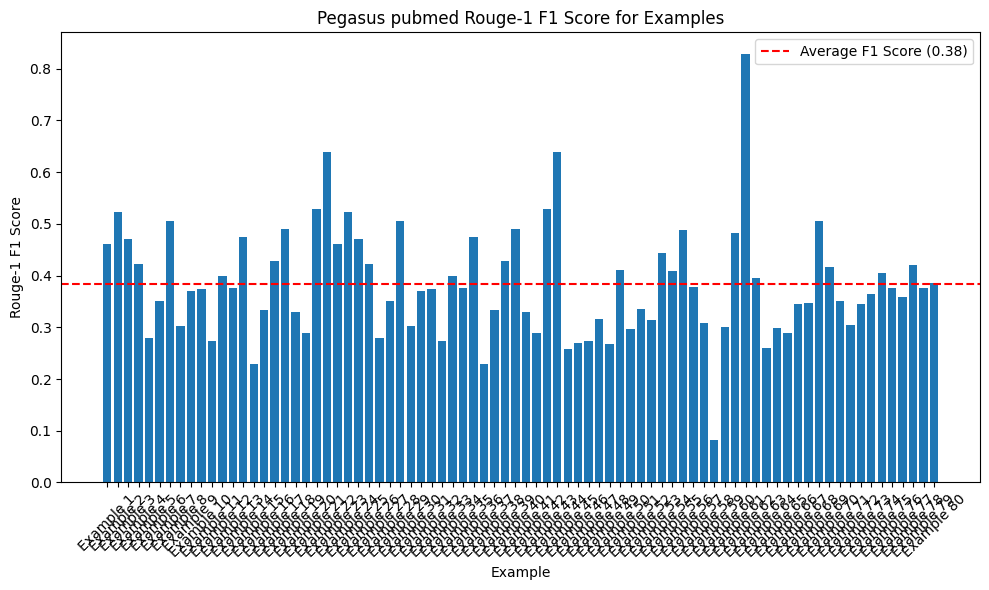

In [91]:
import os
import pandas as pd
import matplotlib.pyplot as plt


csv_file_path = os.path.join(output_dir, f"{formatted_model_name}_{dataset_name}_rouge_scores.csv")
rouge_df = pd.read_csv(csv_file_path)


average_rouge_1_f1 = rouge_df["Rouge-1 F1 Score"].mean()

# Plot the Rouge scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(rouge_df)), rouge_df["Rouge-1 F1 Score"], tick_label=[f"Example {i+1}" for i in range(len(rouge_df))])
plt.axhline(y=average_rouge_1_f1, color='r', linestyle='--', label=f"Average F1 Score ({average_rouge_1_f1:.2f})")
plt.xlabel("Example")
plt.ylabel("Rouge-1 F1 Score")
plt.title("Pegasus pubmed Rouge-1 F1 Score for Examples")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
output_file_name = "Rouge-1_F1_Pegasus_pubmed"
save_path = os.path.join("/content/google_pegasus-pubmed_pubmed_evaluation/rouge", output_file_name)

plt.savefig(save_path)
# Show the plot
plt.show()

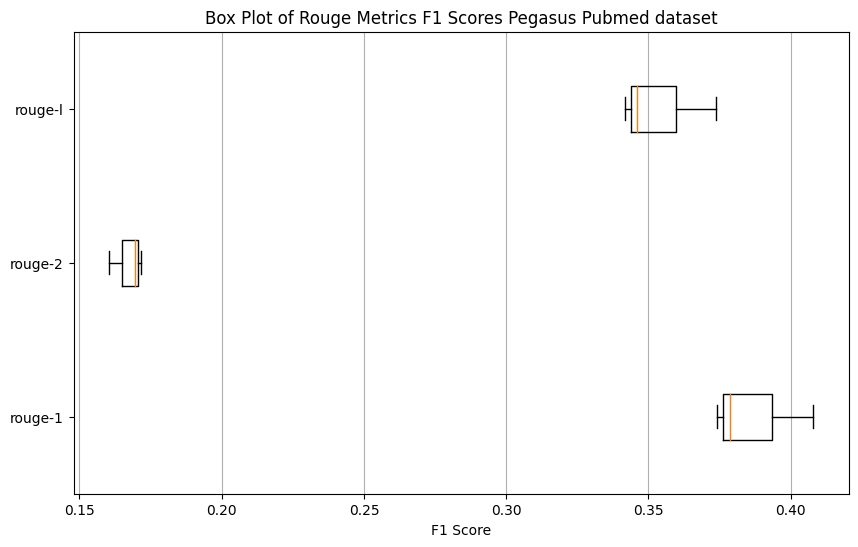

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the average_rouge_df from the CSV file
average_rouge_df = pd.read_csv(os.path.join(output_dir, f"{formatted_model_name}_{dataset_name}_average_rouge_scores.csv"))

# Define the Rouge metrics you want to plot
rouge_metrics = ["rouge-1", "rouge-2", "rouge-l"]

# Create a box plot with the axis flipped
plt.figure(figsize=(10, 6))
plt.boxplot([average_rouge_df[metric] for metric in rouge_metrics], vert=False)
plt.title("Box Plot of Rouge Metrics F1 Scores Pegasus Pubmed dataset")
plt.xlabel("F1 Score")
plt.yticks(range(1, len(rouge_metrics) + 1), rouge_metrics)
plt.grid(axis='x')

output_file_name = "Rouge-1_2_l_Boxplot_pegasus_pubmed"
save_path = os.path.join("/content/google_pegasus-pubmed_pubmed_evaluation/rouge", output_file_name)

plt.savefig(save_path)
plt.show()

In [93]:
bleu_scores = []
meteor_scores = []
total_bleu_score = 0.0
total_meteor_score = 0.0

In [94]:
for i, example in enumerate(test_dataset):
    if i >= 30:
        break

    article = example["article"]
    abstract = example["abstract"]

    # Generate a summary using the sliding_window_summarization function
    summary = sliding_window_summarization_evaluation(article, model=model, tokenizer=tokenizer)

    # Calculate BLEU and METEOR scores (continue as before)
    reference = abstract.split()  # Tokenized reference
    hypothesis_tokens = summary.split()  # Tokenized hypothesis for both BLEU and METEOR
    bleu_score = sentence_bleu([reference], hypothesis_tokens)

    bleu_scores.append(bleu_score)
    total_bleu_score += bleu_score

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [95]:
# Calculate average scores
average_bleu_score = total_bleu_score / num_examples_to_evaluate


In [96]:
bleu_df = pd.DataFrame(bleu_scores, columns=["BLEU Score"])

bleu_output_dir = os.path.join("/content/google_pegasus-arxiv_evaluation", "bleu")

os.makedirs(bleu_output_dir, exist_ok=True)


bleu_df.to_csv(os.path.join(bleu_output_dir, f"{formatted_model_name}_{dataset_name}_bleu_scores.csv"), index=False)

print("Average BLEU Score:", average_bleu_score)



Average BLEU Score: 0.09262203837382812


In [97]:
import matplotlib.pyplot as plt

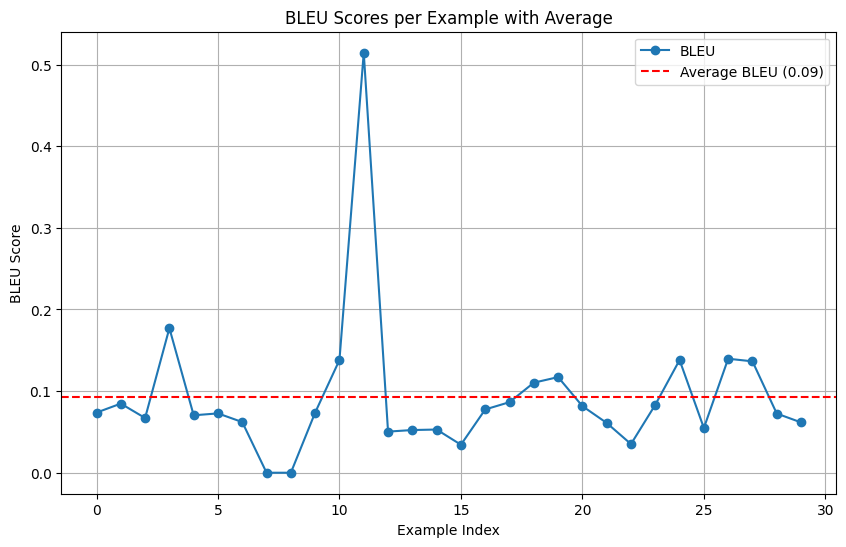

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(bleu_scores, marker='o', linestyle='-', label='BLEU')
plt.axhline(y=average_bleu_score, color='r', linestyle='--', label=f'Average BLEU ({average_bleu_score:.2f})')
plt.title('BLEU Scores per Example with Average Pegasus Pubmed')
plt.xlabel('Example Index')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()
plt.show()